# Attaque

Ce notebook explique comment réaliser une attaque sur des modèles de segmentation et fait également une évaluation des performances et de la transférabilité

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CedricDada/attack_segmentation/blob/main/attaque.ipynb)

### Prise en main segmentation

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

<ipython-input-1-2e6759d1a6c8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


FileNotFoundError: [Errno 2] No such file or directory: 'coco_sample.pth'

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

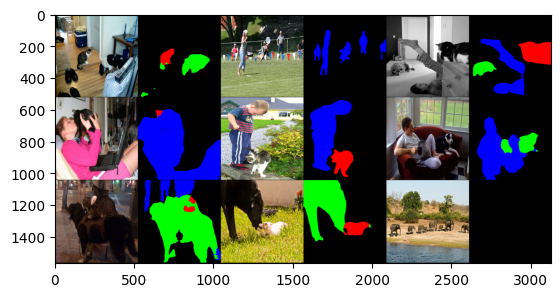

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Le résultat est loin d'être parfait mais on voit que le réseau est "fonctionnel" (il s'agit d'un backbone resnet - au fait beaucoup mieux aujourd'hui mais il faut aller chercher les modèles ailleurs...).

On peut en tester un autre plus rapide (et moins bon) comme torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights:

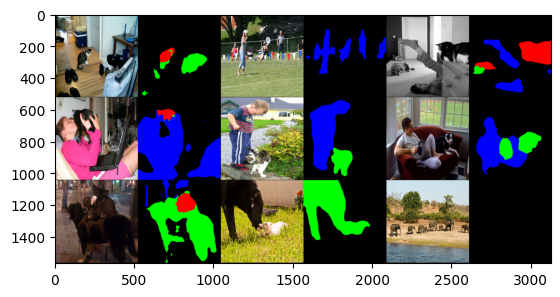

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

### Question 1

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

# Déterminer le device disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Télécharger les données si nécessaire
if not os.path.isfile("coco_sample.pth"):
    os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

# Initialiser le modèle sur le device
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().to(device)

# Remplacer le classifieur
net.classifier = torch.nn.Identity()

# Normalisation
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Charger les images et les déplacer sur le device
img = torch.load("coco_sample.pth", map_location=device)[:3]  # Charger directement sur le device
img = torch.nn.functional.interpolate(img, size=(256, 256), mode="bilinear").to(device)

# Calcul des caractéristiques cibles
with torch.no_grad():
    f_0 = net(normalize(img))["out"]
    f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :].to(device)  # S'assurer du device

# Initialiser la perturbation sur le device
attaque = torch.nn.Parameter(torch.zeros(img.shape, device=device))
optimizer = torch.optim.SGD([attaque], lr=0.005)

# Boucle d'attaque
for i in range(10):
    optimizer.zero_grad()

    # Tous les calculs se font sur le device
    x_perturbed = normalize(img + attaque)
    f = net(x_perturbed)["out"]

    loss = ((f - f_0) ** 2).sum()
    print(f"Iter {i}, Loss: {loss.item():.4f}")

    loss.backward()
    optimizer.step()

    # Application des contraintes
    with torch.no_grad():
        attaque.clamp_(-1/255, 1/255)
        attaque.data = torch.clamp(attaque.data, -img, 1 - img)



Fonction pour la visualisation de l'attaque

In [8]:
def visualize_attack_results(
    attack,
    model,
    original_image,
    normalize_transform,
    fig_size=(16, 16),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Visualise les résultats d'une attaque adversarial pour la segmentation sémantique

    Args:
        attack (Tensor): Tenseur de perturbation généré
        model (nn.Module): Modèle de segmentation pour la visualisation
        original_image (Tensor): Image originale non perturbée
        normalize_transform (transforms.Normalize): Transformation de normalisation
        fig_size (tuple): Taille de la figure matplotlib
        title (str): Titre du graphique
        device (torch.device): Device utilisé pour les calculs
    """

    def create_pred_mask(z):
        """Mapping des classes vers les canaux RGB"""
        pred = torch.zeros_like(original_image).to(device)
        pred[:, 0, :, :] = (z == 1).float()  # Personnes (bleu)
        pred[:, 1, :, :] = (z == 2).float()  # Chats (rouge)
        pred[:, 2, :, :] = (z == 3).float()  # Chiens (vert)
        return pred

    with torch.no_grad():
        # Segmentation originale
        x_clean = normalize_transform(original_image.to(device))
        z_clean = model(x_clean)['out'][:, [0, 8, 12, 15], :, :]
        _, z_clean = z_clean.max(1)

        # Segmentation perturbée
        x_perturbed = normalize_transform(torch.clamp(original_image + attack, 0, 1).to(device))
        z_perturbed = model(x_perturbed)['out'][:, [0, 8, 12, 15], :, :]
        _, z_perturbed = z_perturbed.max(1)

    # Création de la visualisation
    visu = torch.cat([
        original_image.to(device),
        create_pred_mask(z_clean),
        torch.clamp(original_image + attack, 0, 1).to(device),
        create_pred_mask(z_perturbed)
    ], dim=-1)

    # Préparation pour matplotlib
    visu_grid = torchvision.utils.make_grid(visu, nrow=1)
    visu_np = visu_grid.permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()

    # Affichage
    plt.figure(figsize=fig_size)
    plt.imshow(visu_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

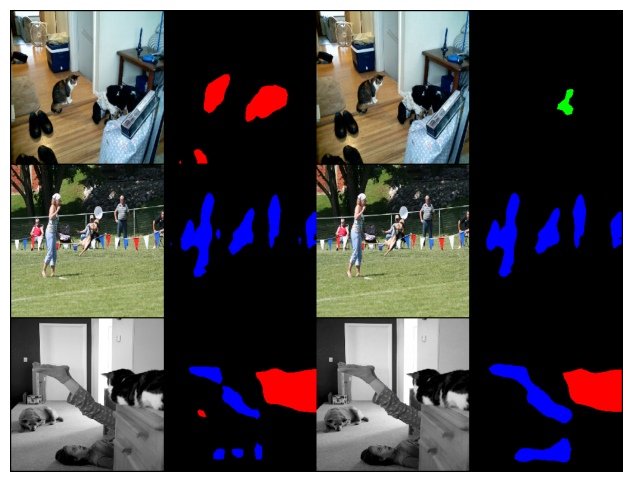

In [ ]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = torch.load("coco_sample.pth")[:3]
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Appel de la fonction
visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]"
)

### Question 2

In [ ]:

# Chargement des données
def load_data(path, size=256):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

In [ ]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor
class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").backbone
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.downsample_factor = 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)  # Retrait du checkpoint pour stabilité
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des images
person_img = load_data("cible4.jpg")
img = load_data("coco_sample.pth")

# Calcul des caractéristiques cibles
with torch.no_grad():
    net = FixedFeatureExtractor().to(device).eval()
    f_target = net(normalize(person_img))
    target_features = f_target  # Utilisation directe des caractéristiques spatiales

# Initialisation de l'attaque
attaque = nn.Parameter(torch.randn_like(img) * 0.1)  # Initialisation avec bruit
optimizer = torch.optim.Adam([attaque], lr=config.lr)

# Modèle de segmentation pour masque
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Boucle d'entraînement
for epoch in range(config.epochs):
    optimizer.zero_grad()

    x_perturbed = torch.clamp(img + attaque, 0, 1)
    features = net(normalize(x_perturbed))

    # Génération du masque cible (tous les objets sauf fond)
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).float()  # Cible tous les objets
        object_mask = torch.nn.functional.interpolate(
            object_mask.unsqueeze(1),
            size=features.shape[-2:],
            mode='nearest'
        )

    # Calcul des pertes
    loss_content = nn.MSELoss()(features * object_mask, target_features * object_mask)
    tv_loss = torch.sum(torch.abs(attaque[:,:,:,:-1] - attaque[:,:,:,1:]))
    loss = loss_content + config.tv_weight * tv_loss

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


In [ ]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Appel de la fonction
visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
    device = torch.device('cpu')
)

### Question 3

In [ ]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500
    epsilons = [0.3, 0.95]#, 0.05, 0.08, 0.1]   Différents niveaux de perturbation

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des données
def load_data(path, size=256):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Modèle de segmentation
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Fonction d'attaque avec contrainte de norme
def run_attack(epsilon):
    # Chargement des données
    person_img = load_data("cible4.jpg")
    img = load_data("coco_sample.pth")

    # Initialisation perturbation
    attaque = nn.Parameter(torch.zeros_like(img, device=device))
    optimizer = torch.optim.Adam([attaque], lr=config.lr)

    # Masque des objets originaux
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).cpu()

    # Entraînement
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        # Contrainte de norme Linf
        attaque.data.clamp_(-epsilon, epsilon)

        x_perturbed = torch.clamp(img + attaque, 0, 1)
        output = seg_model(normalize(x_perturbed))['out']

        # Calcul de la loss (cible : classe personne)
        loss = torch.nn.functional.cross_entropy(
            output,
            torch.full_like(output.argmax(1), 15, device=device) * object_mask.to(device)
        )

        loss.backward()
        optimizer.step()

    # Évaluation
    with torch.no_grad():
        final_seg = seg_model(normalize(x_perturbed))['out'].argmax(1)
        success_rate = ((final_seg == 15) & object_mask.to(device)).float().mean().item()

    return success_rate, attaque.data.abs().max().item()

# Exécution pour différents epsilons
results = []
for eps in config.epsilons:
    sr, actual_eps = run_attack(eps)
    results.append((eps, actual_eps, sr))
    print(f"Epsilon: {eps:.3f} | Perturbation réelle: {actual_eps:.4f} | Taux de succès: {sr:.2%}")

<ipython-input-18-3890544ee165>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


In [ ]:

# Visualisation
eps_values = [r[0] for r in results]
success_rates = [r[2] for r in results]

plt.figure(figsize=(10, 5))
plt.plot(eps_values, success_rates, 'bo-')
plt.xlabel('Valeur maximale de perturbation (ε)')
plt.ylabel('Taux de conversion en "personne"')
plt.title('Efficacité de l\'attaque en fonction de la norme autorisée')
plt.grid(True)
plt.show()

# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


for r in results:
  print("epsilon = "+str(r[0]))
  visualize_attack_results(
      attack=r[1],
      model=net_vis,
      original_image=img,
      normalize_transform=normalize,
      fig_size=(20, 12),
      title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
  )



### Question 4

In [ ]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).cpu().eval()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


for r in results:
  print("epsilon = "+str(r[0]))
  visualize_attack_results(
      attack=r[1],
      model=net_vis,
      original_image=img,
      normalize_transform=normalize,
      fig_size=(20, 12),
      title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
  )

### Question 5

In [6]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 200
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor
class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").backbone
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.downsample_factor = 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)  # Retrait du checkpoint pour stabilité
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des données
def load_data(path, size=200):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

person_img = load_data("cible4.jpg")
img = load_data("coco_sample.pth")

# Initialisation des deux modèles
model_names = ["deeplabv3_resnet50", "fcn_resnet50"]
feature_extractors = []
seg_models = []

for model_name in model_names:
    if model_name == "deeplabv3_resnet50":
        feature_extractor = FixedFeatureExtractor().to(device).eval()
        seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()
    elif model_name == "fcn_resnet50":
        feature_extractor = FixedFeatureExtractor().to(device).eval()
        seg_model = torchvision.models.segmentation.fcn_resnet50(weights="DEFAULT").to(device).eval()
    feature_extractors.append(feature_extractor)
    seg_models.append(seg_model)

# Calcul des caractéristiques cibles pour chaque modèle
target_features_list = []
with torch.no_grad():
    for net in feature_extractors:
        f_target = net(normalize(person_img))
        target_features_list.append(f_target)

# Initialisation de l'attaque
attaque = nn.Parameter(torch.randn_like(img) * 0.1)  # Initialisation avec bruit
optimizer = torch.optim.Adam([attaque], lr=config.lr)

# Boucle d'entraînement
for epoch in range(config.epochs):
    optimizer.zero_grad()
    x_perturbed = torch.clamp(img + attaque, 0, 1)

    total_loss = 0
    for i, net in enumerate(feature_extractors):
        features = net(normalize(x_perturbed))

        # Génération du masque cible (tous les objets sauf fond)
        with torch.no_grad():
            orig_seg = seg_models[i](normalize(img))['out']
            object_mask = (orig_seg.argmax(1) != 0).float()  # Cible tous les objets
            object_mask = torch.nn.functional.interpolate(
                object_mask.unsqueeze(1),
                size=features.shape[-2:],
                mode='nearest'
            )

        # Calcul des pertes
        loss_content = nn.MSELoss()(features * object_mask, target_features_list[i] * object_mask)
        tv_loss = torch.sum(torch.abs(attaque[:,:,:,:-1] - attaque[:,:,:,1:]))
        loss = loss_content + config.tv_weight * tv_loss

        total_loss += loss

    total_loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {total_loss.item():.4f}")

<ipython-input-6-3d288150ec42>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


Epoch 1 | Loss: 484.7458
Epoch 2 | Loss: 479.0435
Epoch 3 | Loss: 473.3838
Epoch 4 | Loss: 467.7724
Epoch 5 | Loss: 462.2077
Epoch 6 | Loss: 456.6918
Epoch 7 | Loss: 451.2271
Epoch 8 | Loss: 445.8078
Epoch 9 | Loss: 440.4359
Epoch 10 | Loss: 435.1120
Epoch 11 | Loss: 429.8337
Epoch 12 | Loss: 424.6008
Epoch 13 | Loss: 419.4149
Epoch 14 | Loss: 414.2746
Epoch 15 | Loss: 409.1812
Epoch 16 | Loss: 404.1353
Epoch 17 | Loss: 399.1359
Epoch 18 | Loss: 394.1827
Epoch 19 | Loss: 389.2762
Epoch 20 | Loss: 384.4145
Epoch 21 | Loss: 379.6000
Epoch 22 | Loss: 374.8318
Epoch 23 | Loss: 370.1108
Epoch 24 | Loss: 365.4346
Epoch 25 | Loss: 360.8038
Epoch 26 | Loss: 356.2170
Epoch 27 | Loss: 351.6758
Epoch 28 | Loss: 347.1828
Epoch 29 | Loss: 342.7339
Epoch 30 | Loss: 338.3270
Epoch 31 | Loss: 333.9641
Epoch 32 | Loss: 329.6472
Epoch 33 | Loss: 325.3762
Epoch 34 | Loss: 321.1490
Epoch 35 | Loss: 316.9606
Epoch 36 | Loss: 312.8166
Epoch 37 | Loss: 308.7188
Epoch 38 | Loss: 304.6632
Epoch 39 | Loss: 300.

<ipython-input-11-a91d126fe8a7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


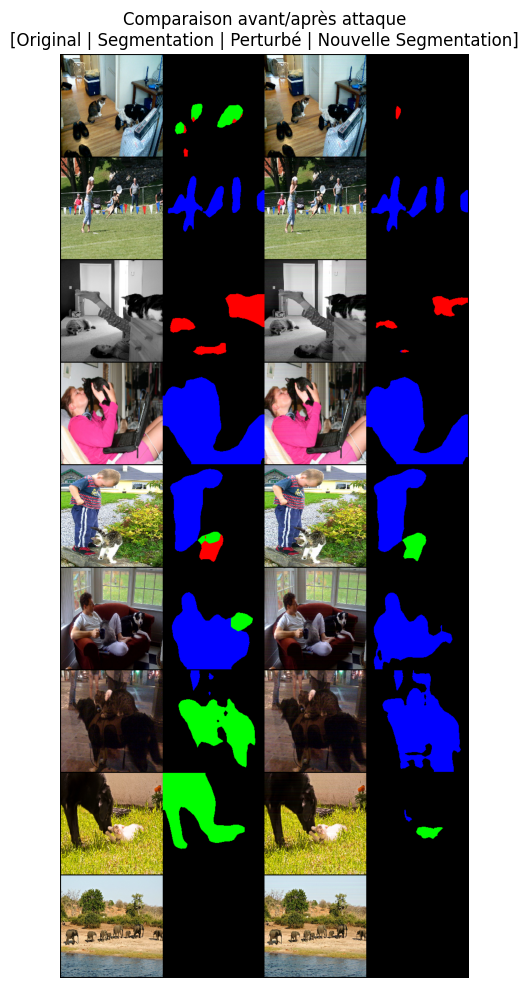

In [12]:

# Visualisation des résultats (à définir selon vos besoins)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)

Etude de la transférabilité

<ipython-input-11-a91d126fe8a7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


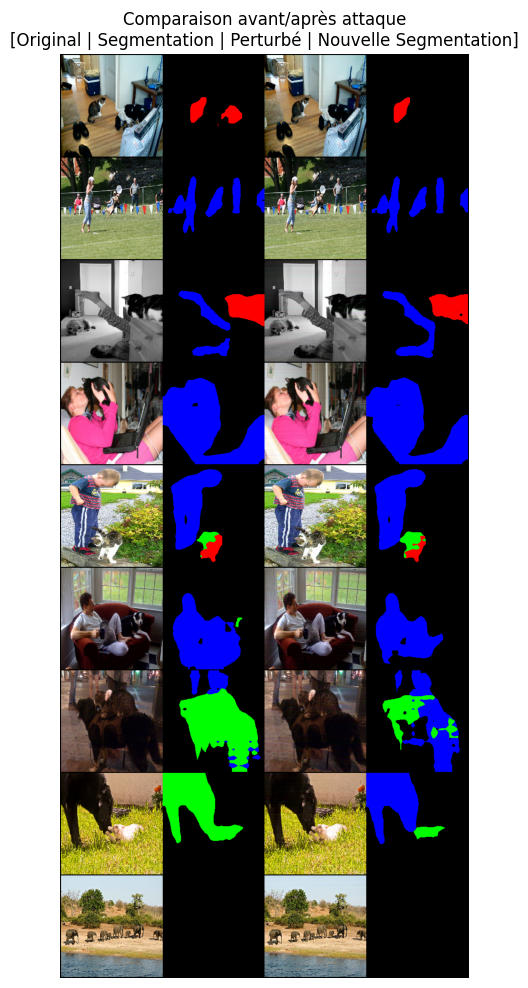

In [15]:

# Visualisation des résultats (à définir selon vos besoins)
seg_model = torchvision.models.segmentation.fcn_resnet50(weights="DEFAULT").cpu().eval()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=seg_model,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)

<ipython-input-11-a91d126fe8a7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


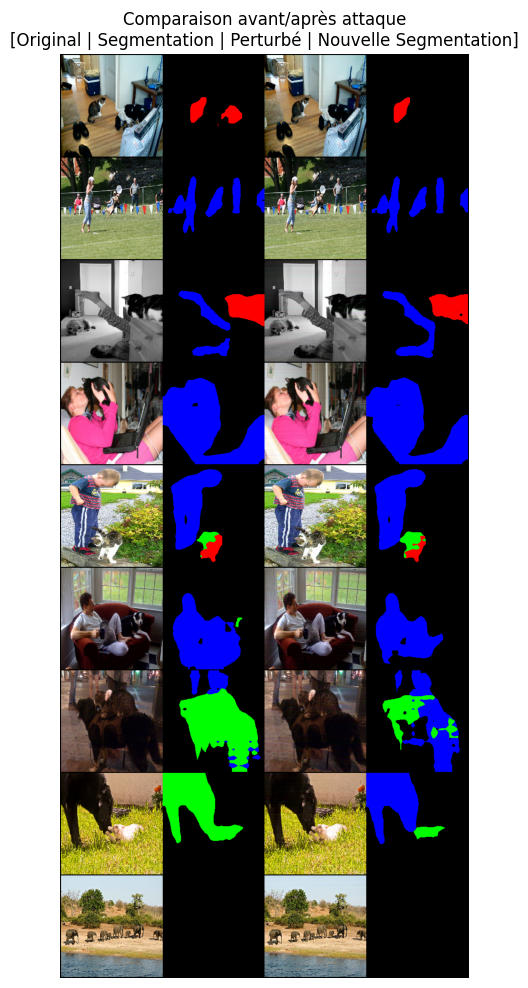

In [17]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).cpu().eval()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=seg_model,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)